In [1]:
import numpy as np
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [3]:
from functionDoESpecial import functionDoESpecial, function_dimensions, function_names
from binomial_optimization import optimization_step, value_generator

In [4]:
f_name = 'ackley1'

# Comparison of GP and GGPM with binomial distribution

In [27]:
n_trials = 25
n_iteration = 120
initial_size = 15
bound = 1
dims = 2

np.random.seed(7)

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=n_trials).reshape(-1, 1)

[-0.00679571]


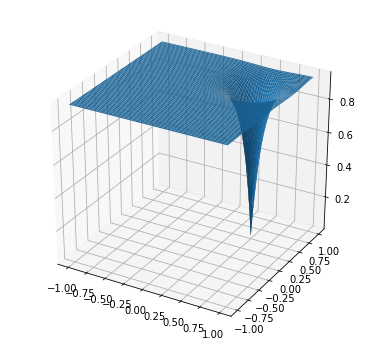

In [5]:
xs = np.linspace(-bound, bound, 300)
ys = np.linspace(-bound, bound, 300)
xs, ys = np.meshgrid(xs, ys)
values = objective(np.dstack([xs, ys]).reshape(90000, 2)).reshape(300, 300)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)
print(objective(argmin.reshape(1, -1)))

Gaussian inference

In [25]:
ker_g = GPy.kern.RBF(dims)

In [ ]:
agg = []

for m in [1, 2, 5, 10]:
    
    mult = []
    
    for attempt in range(10):

        X_g = init_design
        Y_g = init_values * m
        trials_g = np.ones(len(X_g)).reshape(-1, 1) * n_trials * m

        m_g = GPy.models.GPRegression(X_g, Y_g / trials_g, ker_g)
        m_g.optimize()

        model_mins_g = []
        model_mins_g.append(np.min(m_g.predict(X_g)[0]))
        
        model_argmins_g = []
        model_argmins_g.append(np.argmin(m_g.predict(X_g)[0]))

        for i in range(n_iteration):
            v_g = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, v_g, lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds, trials=trials_g,\
                                                        n_trials_low=n_trials*m, kernel=ker_g)
            model_mins_g.append(np.min(m_g.predict(X_g)[0]))
            model_argmins_g.append(np.argmin(m_g.predict(X_g)[0]))
        
        mult.append(np.array([np.array(model_mins_g), X_g, Y_g, trials_g, np.array(model_argmins_g)]))
        
    agg.append(mult)
    
agg = np.array(agg)

Approx inference

In [ ]:
ker_l = GPy.kern.RBF(dims)

In [ ]:
agg_l = []

for m in [1, 2]:
    
    mult = []
    
    for attempt in range(5):

        X_l = init_design
        Y_l = init_values * m
        trials_l = np.ones(len(X_l)).reshape(-1, 1) * n_trials * m

        m_l = GPy.core.GP(X_l, Y_l, kernel=ker_l, 
                          Y_metadata={'trials': trials_l},
                          inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                          likelihood=GPy.likelihoods.Binomial())
        m_l.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins_l = []
        model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
        
        model_argmins_l = []
        model_argmins_l.append(np.argmin(m_l._raw_predict(X_l)[0]))

        for i in range(n_iteration):
            v_l = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X_l, Y_l, trials_l, m_l = optimization_step(X_l, Y_l, v_l, lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds, trials=trials_l,\
                                                        n_trials_low=n_trials * m, method='laplace',\
                                                        kernel=ker_l)
            model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
            model_argmins_l.append(np.argmin(m_l._raw_predict(X_l)[0]))
        
        mult.append(np.array([np.array(model_mins_l), X_l, Y_l, trials_l, np.array(model_argmins_l)]))
        
    agg_l.append(mult)
    
agg_l = np.array(agg_l)

In [14]:
def return_track(agg, objective, type_track='true'):
    
    tracks = []
    
    if type_track=='true':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                argmins = agg[i, j, 1][agg[i, j, 4]]
                values = objective(argmins)
                subtracks.append(values)
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)
        
            
    
    elif type_track=='noisy':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                subtracks.append(np.minimum.accumulate(agg[i, j, 2] / agg[i, j, 3]))
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)

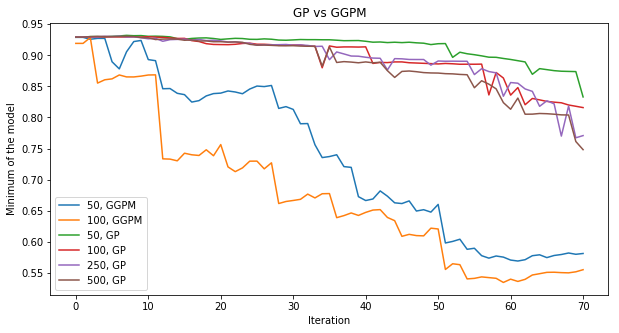

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(agg_l[0, :, 0].mean(), label='50, GGPM')
plt.plot(agg_l[1, :, 0].mean(), label='100, GGPM')

plt.plot(agg[0, :, 0].mean(), label='50, GP')
plt.plot(agg[1, :, 0].mean(), label='100, GP')
plt.plot(agg[2, :, 0].mean(), label='250, GP')
plt.plot(agg[3, :, 0].mean(), label='500, GP')
plt.title('GP vs GGPM')
plt.xlabel('Iteration')
plt.ylabel('Minimum of the model')
plt.legend()
plt.show()

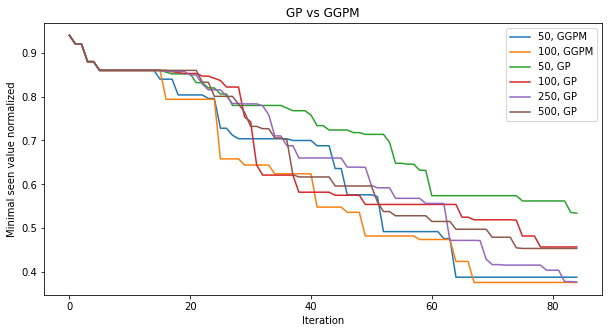

In [48]:
# numpy.minimum.accumulate()
plt.figure(figsize=(10, 5))
plt.plot(np.array([np.minimum.accumulate(agg_l[0, i, 2] / agg_l[0, i, 3]) for i in range(agg_l.shape[1])]).mean(axis=0), label='50, GGPM')
plt.plot(np.array([np.minimum.accumulate(agg_l[1, i, 2] / agg_l[1, i, 3]) for i in range(agg_l.shape[1])]).mean(axis=0), label='100, GGPM')

plt.plot(np.array([np.minimum.accumulate(agg[0, i, 2] / agg[0, i, 3]) for i in range(agg.shape[1])]).mean(axis=0), label='50, GP')
plt.plot(np.array([np.minimum.accumulate(agg[1, i, 2] / agg[1, i, 3]) for i in range(agg.shape[1])]).mean(axis=0), label='100, GP')
plt.plot(np.array([np.minimum.accumulate(agg[2, i, 2] / agg[2, i, 3]) for i in range(agg.shape[1])]).mean(axis=0), label='250, GP')
plt.plot(np.array([np.minimum.accumulate(agg[3, i, 2] / agg[3, i, 3]) for i in range(agg.shape[1])]).mean(axis=0), label='500, GP')
plt.title('GP vs GGPM')
plt.xlabel('Iteration')
plt.ylabel('Minimal seen value normalized')
plt.legend()
plt.show()

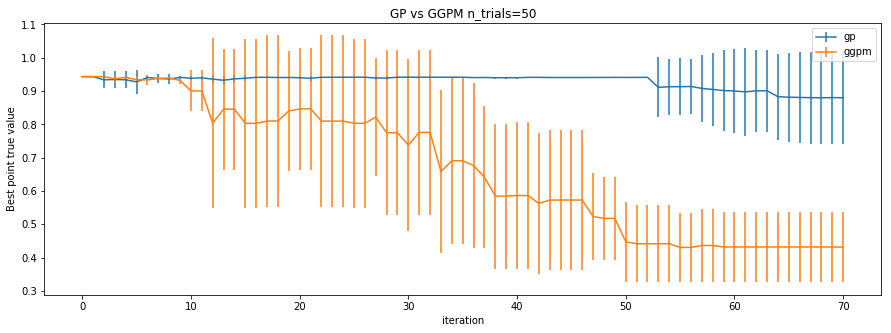

In [47]:
means, stds = return_track(agg, objective)
means_l, stds_l = return_track(agg_l, objective)

plt.figure(figsize=(15, 5))
plt.title('GP vs GGPM n_trials=50')
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp')
plt.errorbar(np.arange(len(means_l[0])),  means_l[0], yerr=stds_l[0], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

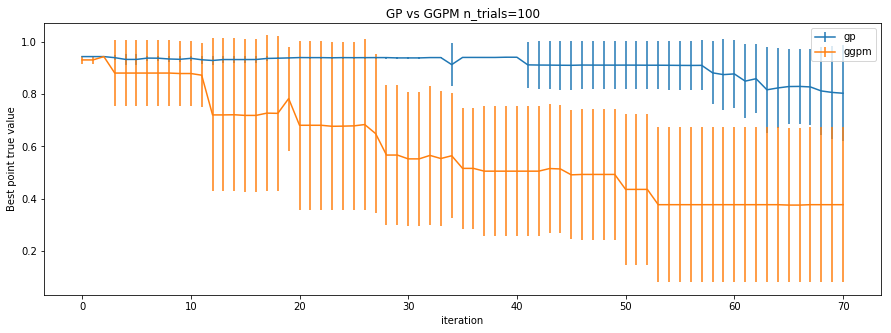

In [50]:
means, stds = return_track(agg, objective)
means_l, stds_l = return_track(agg_l, objective)

plt.figure(figsize=(15, 5))
plt.title('GP vs GGPM n_trials=100')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='gp')
plt.errorbar(np.arange(len(means_l[1])),  means_l[1], yerr=stds_l[1], label='ggpm')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

In [38]:
with open('Results/GP_vs_GGPM/GP_50_100_250_500_ackley1_2d_-1_1.pickle', 'wb') as f:
    pickle.dump(agg, f)
    
with open('Results/GP_vs_GGPM/GGPM_50_100_ackley1_2d_-1_1.pickle', 'wb') as f:
    pickle.dump(agg_l, f)   

# Multi fidelity vs single fidelity

2d

In [28]:
ker_f = GPy.kern.RBF(dims)

In [ ]:
agg_f = []

for p, d_fid in [(0, False), (0.5, True), (1, False)]:
    
    mult = []
    
    for attempt in range(10):

        X = init_design
        Y = init_values
        trials = np.ones(len(X)).reshape(-1, 1) * n_trials

        m = GPy.core.GP(X, Y, kernel=ker_f, 
                        Y_metadata={'trials': trials},
                        inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                        likelihood=GPy.likelihoods.Binomial())
        m.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
        
        model_argmins = []
        model_argmins.append(np.argmin(m._raw_predict(X)[0]))

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=n_trials, n_trials_high=3*n_trials,\
                                                method='laplace', kernel=ker_f, treshold_proba=p, \
                                                dinamic_treshold=d_fid)
            model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
            model_argmins.append(np.argmin(m._raw_predict(X)[0]))
        
        mult.append(np.array([np.array(model_mins), X, Y, trials, np.array(model_argmins)]))
        
    agg_f.append(mult)
    
agg_f = np.array(agg_f)

In [ ]:
agg_f2 = []

for p, d_fid in [(0.5, False)]:
    
    mult = []
    
    for attempt in range(10):

        X = init_design
        Y = init_values
        trials = np.ones(len(X)).reshape(-1, 1) * n_trials

        m = GPy.core.GP(X, Y, kernel=ker_f, 
                        Y_metadata={'trials': trials},
                        inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                        likelihood=GPy.likelihoods.Binomial())
        m.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
        
        model_argmins = []
        model_argmins.append(np.argmin(m._raw_predict(X)[0]))

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=n_trials, n_trials_high=3*n_trials,\
                                                method='laplace', kernel=ker_f, treshold_proba=p, \
                                                dinamic_treshold=d_fid)
            model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
            model_argmins.append(np.argmin(m._raw_predict(X)[0]))
        
        mult.append(np.array([np.array(model_mins), X, Y, trials, np.array(model_argmins)]))
        
    agg_f2.append(mult)
    
agg_f2 = np.array(agg_f2)

25.77777777777778


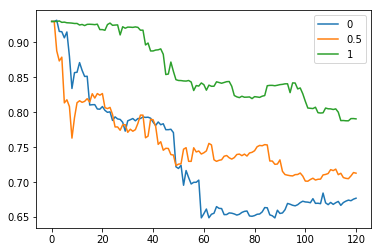

In [31]:
plt.plot(agg_f[0, :, 0].mean(), label='0')
plt.plot(agg_f[1, :, 0].mean(), label='0.5')
plt.plot(agg_f[2, :, 0].mean(), label='1')
plt.legend()

print(agg_f[1, :, 3].mean().mean())

25.77777777777778


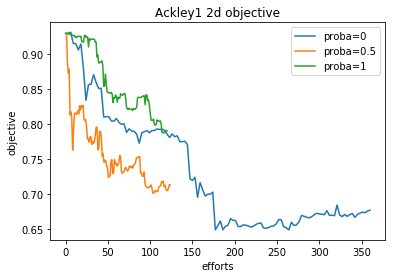

In [32]:
plt.plot(np.linspace(0, 120, 121)*3, agg_f[0, :, 0].mean(), label='proba=0')
plt.plot(np.linspace(0, 120, 121)*25.77/25, agg_f[1, :, 0].mean(), label='proba=0.5')
plt.plot(agg_f[2, :, 0].mean(), label='proba=1')
plt.legend()
plt.title('Ackley1 2d objective')
plt.xlabel('efforts')
plt.ylabel('objective')

print(agg_f[1, :, 3].mean().mean())

25.77777777777778


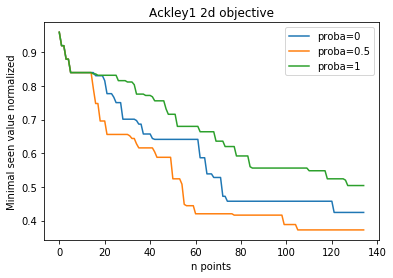

In [33]:
plt.plot(np.array([np.minimum.accumulate(agg_f[0, i, 2] / agg_f[0, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=0')
plt.plot(np.array([np.minimum.accumulate(agg_f[1, i, 2] / agg_f[1, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=0.5')
plt.plot(np.array([np.minimum.accumulate(agg_f[2, i, 2] / agg_f[2, i, 3]) for i in range(agg_f.shape[1])]).mean(axis=0), label='proba=1')
plt.legend()
plt.title('Ackley1 2d objective')
plt.xlabel('n points')
plt.ylabel('Minimal seen value normalized')

print(agg_f[1, :, 3].mean().mean())

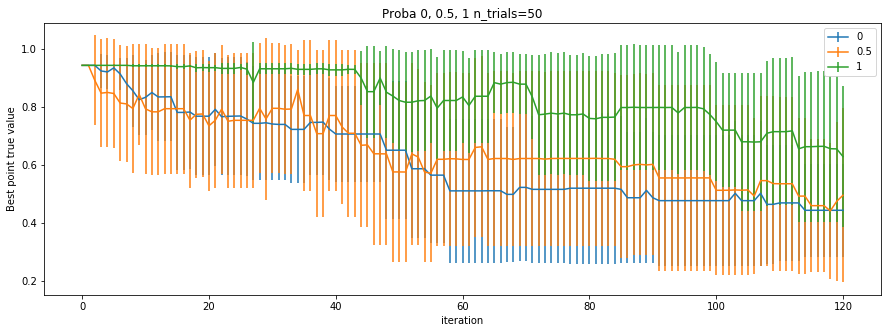

In [34]:
means_f, stds_f = return_track(agg_f, objective)

plt.figure(figsize=(15, 5))
plt.title('Proba 0, 0.5, 1 n_trials=50')
plt.errorbar(np.arange(len(means_f[0])),  means_f[0], yerr=stds_f[0], label='0')
plt.errorbar(np.arange(len(means_f[1])),  means_f[1], yerr=stds_f[1], label='0.5')
plt.errorbar(np.arange(len(means_f[2])),  means_f[2], yerr=stds_f[2], label='1')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

In [131]:
print(agg_f[0, :, 3].mean().mean(), agg_f[1, :, 3].mean().mean(), agg_f[2, :, 3].mean().mean())

132.35294117647058 66.3529411764706 50.0


In [26]:
with open('Results/single_vs_multi/GGPM_proba_0_comp_with_ei_1_ackley1_2d_-1_1.pickle', 'wb') as f:
    pickle.dump(agg_f, f)

Harder case

In [125]:
n_trials = 200
n_iteration = 50
initial_size = 10
bound = 1.5
dims = 2

np.random.seed(7)

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=n_trials).reshape(-1, 1)

In [ ]:
agg_f_h = []

for p in [0, 0.5, 1]:
    
    mult = []
    
    for attempt in range(10):

        X = init_design
        Y = init_values
        trials = np.ones(len(X)).reshape(-1, 1) * n_trials

        m = GPy.core.GP(X, Y, kernel=ker_f, 
                        Y_metadata={'trials': trials},
                        inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                        likelihood=GPy.likelihoods.Binomial())
        m.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
        
        model_argmins = []
        model_argmins.append(np.argmin(m._raw_predict(X)[0]))

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=n_trials, n_trials_high=5*n_trials,\
                                                method='laplace', kernel=ker_f, treshold_proba=p)
            model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
            model_argmins.append(np.argmin(m._raw_predict(X)[0]))
        
        mult.append(np.array([np.array(model_mins), X, Y, trials, np.array(model_argmins)]))
        
    agg_f_h.append(mult)
    
agg_f_h = np.array(agg_f_h)

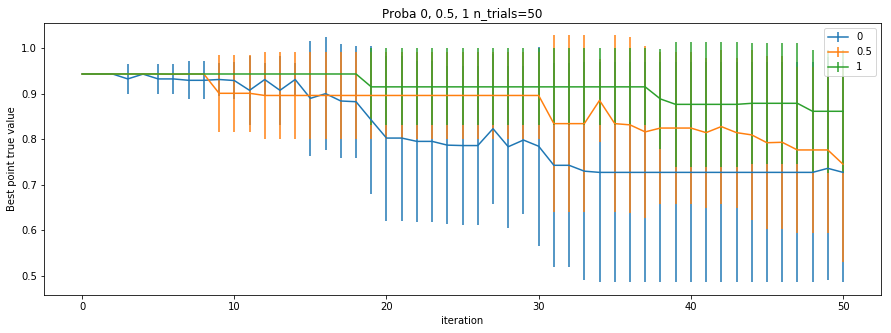

In [127]:
means_f, stds_f = return_track(agg_f_h, objective)

plt.figure(figsize=(15, 5))
plt.title('Proba 0, 0.5, 1 n_trials=50')
plt.errorbar(np.arange(len(means_f[0])),  means_f[0], yerr=stds_f[0], label='0')
plt.errorbar(np.arange(len(means_f[1])),  means_f[1], yerr=stds_f[1], label='0.5')
plt.errorbar(np.arange(len(means_f[2])),  means_f[2], yerr=stds_f[2], label='1')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

In [129]:
agg_f_h[1, :, 3].mean().mean()

472.0

one another case

In [132]:
n_trials = 25
n_iteration = 50
initial_size = 10
# bound = 1.5
dims = 2

np.random.seed(7)

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [0] * dims
upper_bounds = [1] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=n_trials).reshape(-1, 1)

In [ ]:
agg_f_h = []

for p in [0, 0.5, 1]:
    
    mult = []
    
    for attempt in range(10):

        X = init_design
        Y = init_values
        trials = np.ones(len(X)).reshape(-1, 1) * n_trials

        m = GPy.core.GP(X, Y, kernel=ker_f, 
                        Y_metadata={'trials': trials},
                        inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                        likelihood=GPy.likelihoods.Binomial())
        m.optimize()

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
        
        model_argmins = []
        model_argmins.append(np.argmin(m._raw_predict(X)[0]))

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=n_trials, n_trials_high=5*n_trials,\
                                                method='laplace', kernel=ker_f, treshold_proba=p)
            model_mins.append(lik.gp_link.transf(np.min(m._raw_predict(X)[0])))
            model_argmins.append(np.argmin(m._raw_predict(X)[0]))
        
        mult.append(np.array([np.array(model_mins), X, Y, trials, np.array(model_argmins)]))
        
    agg_f_h.append(mult)
    
agg_f_h = np.array(agg_f_h)

In [135]:
from copy import copy
kek = copy(agg_f_h)

In [136]:
kek2 = copy(kek)

In [141]:
[a.tolist() for a in kek2.tolist()]

[[0.9330704515391965,
  0.9321877835002591,
  0.942037355960483,
  0.9377350051419572,
  0.9412256500690542,
  0.9425710778929585,
  0.9397413842694152,
  0.9404806140650329,
  0.9408399051262945,
  0.9414776819074634,
  0.9404892532697814,
  0.9413075857649403,
  0.9415704660084059,
  0.9418435221362365,
  0.9422055408366647,
  0.9429810996700012,
  0.9409812721478127,
  0.941204403807675,
  0.9415624509908592,
  0.9413340848944666,
  0.9412711501373012,
  0.941349788368204,
  0.9068965253698125,
  0.912153078618823,
  0.7982242965499589,
  0.8009798958323081,
  0.8034816711303503,
  0.8031505403574328,
  0.795841445682394,
  0.7979535105705329,
  0.7968107330381897,
  0.7971172176527395,
  0.805120375563126,
  0.8051912643869318,
  0.8058869510966031,
  0.8072174574254214,
  0.8116136076594558,
  0.8140196360182015,
  0.8104082886961009,
  0.8112381298812386,
  0.8089671671362502,
  0.8082376278529748,
  0.8092833669655226,
  0.8097594791622748,
  0.8101687971499286,
  0.811085627703

# Testing part

In [63]:
ker_g = GPy.kern.RBF(dims)

In [64]:
X_g = init_design
Y_g = init_values
trials_g = np.ones(len(X_g)).reshape(-1, 1) * n_trials

m_g = GPy.models.GPRegression(X_g, Y_g / trials_g, ker_g)
m_g.optimize()

model_mins_g = []
model_mins_g.append(np.min(m_g.predict(X_g)[0]))

for i in range(n_iteration):
    v_g = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, v_g, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials_g,\
                                                n_trials_low=n_trials, kernel=ker_g)
    model_mins_g.append(np.min(m_g.predict(X_g)[0]))

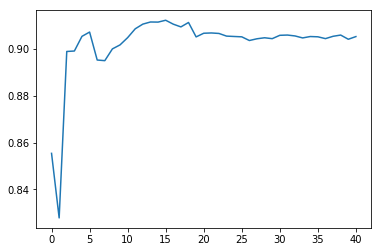

In [65]:
plt.plot(model_mins_g)

In [107]:
ker_l = GPy.kern.RBF(dims)

In [108]:
X_l_lf = init_design
Y_l_lf = init_values
trials_l_lf = np.ones(len(X_l_lf)).reshape(-1, 1) * n_trials

m_l_lf = GPy.core.GP(X_l_lf, Y_l_lf, kernel=ker_l, 
                     Y_metadata={'trials': trials_l_lf},
                     inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                     likelihood=GPy.likelihoods.Binomial())
m_l_lf.optimize()

lik = GPy.likelihoods.Bernoulli()
model_mins_l_lf = []
model_mins_l_lf.append(lik.gp_link.transf(np.min(m_l_lf._raw_predict(X_l_lf)[0])))

for i in range(n_iteration):
    v_l_lf = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_l_lf, Y_l_lf, trials_l_lf, m_l_lf = optimization_step(X_l_lf, Y_l_lf, v_l_lf, lower_bounds=lower_bounds,\
                                                            upper_bounds=upper_bounds, trials=trials_l_lf,\
                                                            n_trials_low=n_trials, method='laplace',\
                                                            kernel=ker_l)
    model_mins_l_lf.append(lik.gp_link.transf(np.min(m_l_lf._raw_predict(X_l_lf)[0])))

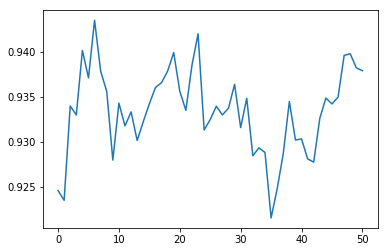

In [109]:
plt.plot(model_mins_l_lf)

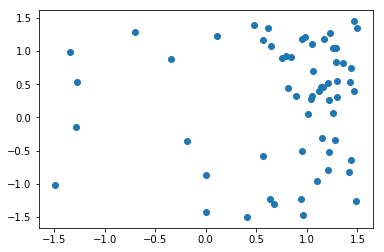

In [121]:
plt.scatter(X_l_lf[:, 0], X_l_lf[:, 1])

In [123]:
X_l_hf = init_design
Y_l_hf = init_values
trials_l_hf = np.ones(len(X_l_hf)).reshape(-1, 1) * n_trials

m_l_hf = GPy.core.GP(X_l_hf, Y_l_hf, kernel=GPy.kern.RBF(2), 
                     Y_metadata={'trials': trials_l_hf},
                     inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                     likelihood=GPy.likelihoods.Binomial())

lik = GPy.likelihoods.Bernoulli()
model_mins_l_hf = []
model_mins_l_hf.append(lik.gp_link.transf(np.min(m_l_hf._raw_predict(X_l_hf)[0])))

for i in range(n_iteration):
    v_l_hf = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
    X_l_hf, Y_l_hf, trials_l_hf, m_l_hf = optimization_step(X_l_hf, Y_l_hf, v_l_hf, lower_bounds=lower_bounds,\
                                                            upper_bounds=upper_bounds, trials=trials_l_hf,\
                                                            n_trials_low=n_trials * 25, method='laplace',\
                                                            kernel=GPy.kern.RBF(2))
    model_mins_l_hf.append(lik.gp_link.transf(np.min(m_l_hf._raw_predict(X_l_hf)[0])))

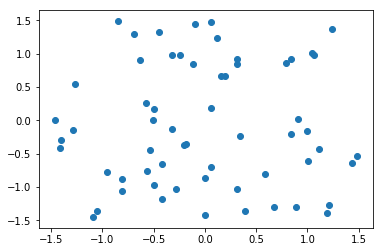

In [122]:
plt.scatter(X_l_hf[:, 0], X_l_hf[:, 1])

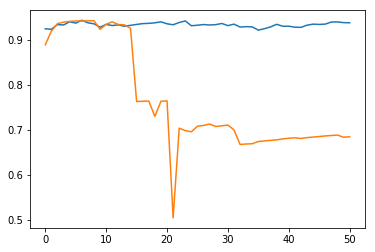

In [124]:
plt.plot(model_mins_l_lf)
plt.plot(model_mins_l_hf)

In [117]:
X_l_lf

array([[-1.27107513e+00,  5.37689988e-01],
       [ 8.39756377e-01,  9.11217108e-01],
       [-1.84772306e-01, -3.57176601e-01],
       [ 6.70395533e-01, -1.30219096e+00],
       [ 1.43396854e+00, -6.35563202e-01],
       [ 1.15487611e-01,  1.22878058e+00],
       [ 3.36139098e-03, -8.59843939e-01],
       [-1.28384660e+00, -1.43628115e-01],
       [-6.94683060e-01,  1.29361806e+00],
       [-3.52497523e-04, -1.42530232e+00],
       [ 9.62167671e-01, -1.46694951e+00],
       [ 5.61849165e-01, -5.78131840e-01],
       [ 1.48669113e+00, -1.25237450e+00],
       [ 6.37849275e-01, -1.22819532e+00],
       [ 1.21608427e+00, -5.18693492e-01],
       [ 9.55383716e-01, -5.09189027e-01],
       [ 1.20987489e+00, -7.85565414e-01],
       [ 1.14642286e+00, -3.15202808e-01],
       [ 1.10363130e+00, -9.52135459e-01],
       [ 1.05330733e+00,  3.16123445e-01],
       [ 1.14380429e+00,  4.64190820e-01],
       [ 1.21697314e+00,  2.61449941e-01],
       [ 1.36153078e+00,  8.21159133e-01],
       [ 9.

In [120]:
Y_l_hf/trials_l_hf

array([[0.2  ],
       [0.185],
       [0.2  ],
       [0.18 ],
       [0.185],
       [0.19 ],
       [0.19 ],
       [0.19 ],
       [0.19 ],
       [0.18 ],
       [0.95 ],
       [0.93 ],
       [0.925],
       [0.935],
       [0.955],
       [0.95 ],
       [0.945],
       [0.965],
       [0.935],
       [0.935],
       [0.905],
       [0.94 ],
       [0.95 ],
       [0.935],
       [0.895],
       [0.94 ],
       [0.94 ],
       [0.945],
       [0.94 ],
       [0.93 ],
       [0.96 ],
       [0.945],
       [0.915],
       [0.955],
       [0.935],
       [0.94 ],
       [0.895],
       [0.955],
       [0.96 ],
       [0.925],
       [0.97 ],
       [0.95 ],
       [0.94 ],
       [0.945],
       [0.95 ],
       [0.945],
       [0.93 ],
       [0.97 ],
       [0.955],
       [0.965],
       [0.97 ],
       [0.975],
       [0.975],
       [0.96 ],
       [0.935],
       [0.94 ],
       [0.955],
       [0.955],
       [0.965],
       [0.935]])

In [11]:
low_f = 25
high_f = 75
n_iteration = 1
initial_size = 15
init_strategy = 'random'
bound = 1
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design(init_strategy, feasible_region, initial_size)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

init_values = value_generator(init_design, objective, n_trials=low_f).reshape(-1, 1)

ker = GPy.kern.RBF(dims)

agg = []

for fid in [low_f, high_f]:

    mult = []

    for attempt in range(1):

        X = init_design
        Y = init_values * int(fid / low_f)
        trials = np.ones(len(X)).reshape(-1, 1) * low_f * int(fid / low_f)

        model_mins = []
        model_argmins = []

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=fid, kernel=ker)
            model_mins.append(float(np.min(m.predict(X)[0])))
            model_argmins.append(int(np.argmin(m.predict(X)[0])))

        mult.append([model_mins, X.astype(float).tolist(), Y.astype(int).tolist(), trials.astype(int).tolist(),\
                     model_argmins])

    agg.append(mult)

for p, d_fid in [(0, False), (1, False), (0.5, False), (0.5, True)]:

    mult = []

    for attempt in range(1):

        X = init_design
        if p < 1:
            Y = init_values
            trials = np.ones(len(X)).reshape(-1, 1) * low_f
        else:
            Y = init_values * int(high_f / low_f)
            trials = np.ones(len(X)).reshape(-1, 1) * int(high_f / low_f)

        lik = GPy.likelihoods.Bernoulli()
        model_mins = []
        model_argmins = []

        for i in range(n_iteration):
            v = lambda x, n_trials: value_generator(x, objective, n_trials=n_trials)
            X, Y, trials, m = optimization_step(X, Y, v, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials,\
                                                n_trials_low=low_f, n_trials_high=high_f,\
                                                method='laplace', kernel=ker, treshold_proba=p, \
                                                dinamic_treshold=d_fid)
            model_mins.append(float(lik.gp_link.transf(np.min(m._raw_predict(X)[0]))))
            model_argmins.append(int(np.argmin(m._raw_predict(X)[0])))

        mult.append([model_mins, X.astype(float).tolist(), Y.astype(int).tolist(), trials.astype(int).tolist(),\
                     model_argmins])

    agg.append(mult)

In [13]:
import json

with open(f_name+'_'+str(low_f)+'_'+str(high_f)+'_'+str(n_iteration)+'_'+str(initial_size)+'_'+init_strategy+'_'+\
              str(bound)+'_'+'dims', 'w') as tf:
        json.dump(agg, tf)

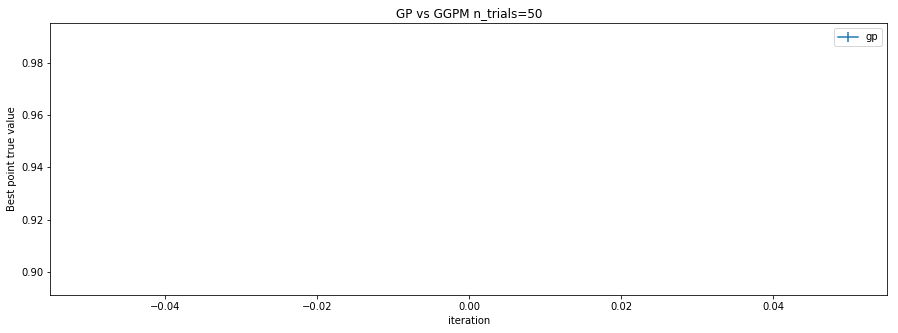

In [44]:
means, stds = return_track(agg_c, objective)

plt.figure(figsize=(15, 5))
plt.title('GP vs GGPM n_trials=50')
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

In [45]:
means

array([[0.94320344],
       [0.94320344],
       [0.94320344],
       [0.94320344],
       [0.94320344],
       [0.94320344]])

In [36]:
agg_c = np.array(agg)

In [42]:
for i in range(len(agg_c)):
    for j in range(len(agg_c[i])):
        for k in range(len(agg_c[i,j])):
            agg_c[i,j,k] = np.array(agg_c[i,j,k])

In [43]:
agg_c

array([[[array([0.93845779]),
         array([[ 0.21960676, -0.04985999],
       [ 0.11325094, -0.72124816],
       [ 0.88825376, -0.94856039],
       [-0.32467699,  0.07920149],
       [-0.37495927, -0.12786119],
       [-0.91421974, -0.51545825],
       [-0.06107449, -0.29004064],
       [ 0.13091416, -0.59882685],
       [ 0.49238802,  0.17562008],
       [-0.32870941,  0.84858144],
       [ 0.24064532, -0.18639601],
       [-0.81635397, -0.73274267],
       [-0.69975125,  0.71794438],
       [-0.59548071, -0.89884851],
       [-0.74928526, -0.33199976],
       [ 0.9405439 , -0.28016855]]),
         array([[24],
       [23],
       [23],
       [24],
       [25],
       [21],
       [25],
       [25],
       [21],
       [24],
       [23],
       [22],
       [25],
       [24],
       [23],
       [23]]),
         array([[25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
  